# 5 Minute Tutorial

Show an example use case of `niftidataset`

## Setup notebook

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision.transforms as torch_tfms

 Support in-notebook plotting

In [2]:
%matplotlib inline

Report versions

In [3]:
print('numpy version: {}'.format(np.__version__))
from matplotlib import __version__ as mplver
print('matplotlib version: {}'.format(mplver))

numpy version: 1.15.3
matplotlib version: 3.0.0


In [4]:
pv = sys.version_info
print('python version: {}.{}.{}'.format(pv.major, pv.minor, pv.micro))

python version: 3.7.0


Reload packages where content for package development

In [5]:
%load_ext autoreload
%autoreload 2

## Define test images

In [6]:
data_dir = '../tests/test_data/images/'

## Setup a niftidataset class

In [7]:
from niftidataset import *

In [8]:
tfms = torch_tfms.Compose([RandomCrop2D(32, None), ToTensor()])
ds = NiftiDataset(data_dir, data_dir, tfms)

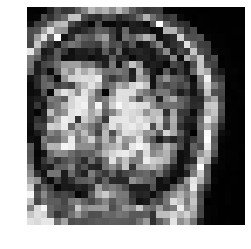

In [9]:
src,tgt = ds[0]
plt.imshow(np.rot90(src), cmap='gist_gray')
plt.axis('off');

Note that this image is a very downsampled image from the publicly available [Kirby 21](https://www.nitrc.org/projects/multimodal) dataset.

## Test fastai

This is not required for this tutorial but this is just a (silly) example of how to use fastai with this package

In [10]:
import fastai as fai
import fastai.vision as faiv
import torchvision
from torch.utils.data import DataLoader

In [11]:
print(f'fastai version: {fai.__version__}')
print(f'pytorch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

fastai version: 1.0.12
pytorch version: 1.0.0.dev20181014
torchvision version: 0.2.1


In [12]:
def my_collate(batch):
    x = torch.stack([torch.stack([b[0],b[0],b[0]]) for b in batch])
    y = torch.stack([b[1].contiguous().view(-1) for b in batch])
    return (x, y)

In [13]:
tdl = DataLoader(ds, batch_size=2)
vdl = DataLoader(ds, batch_size=2)

idb = faiv.ImageDataBunch(tdl, vdl, collate_fn=my_collate)

In [14]:
# create a custom head since the ConvLearner creates a head for a classification task

head = nn.Sequential(
        fai.AdaptiveConcatPool2d(), 
        fai.Flatten(),
        nn.Linear(1024,32**2),
        nn.ReLU(True),
        nn.Linear(32**2, 32**2))

In [15]:
loss = nn.MSELoss()
loss.__name__ = 'MSE'

In [16]:
learner = faiv.ConvLearner(idb, faiv.models.resnet18, 
                           custom_head=head, 
                           loss_func=loss, 
                           metrics=[loss])

In [17]:
faiv.num_features(learner.model)

512

In [18]:
# test that the loss function and dataloaders are working as expected

for x,y in idb.train_dl:
    print(loss(learner.model(x),y))
    break
    
for x,y in idb.valid_dl:
    print(loss(learner.model(x),y))
    break

tensor(84391067648., grad_fn=<MseLossBackward>)
tensor(139998986240., grad_fn=<MseLossBackward>)


In [19]:
learner.lr_find();

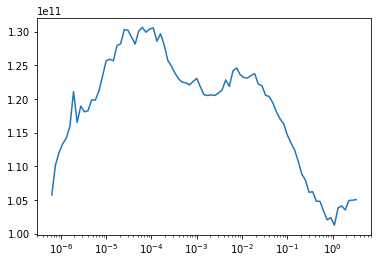

In [20]:
learner.recorder.plot()

In [21]:
learner.fit(1)

Total time: 00:00
epoch  train loss  valid loss  MSE                                 
1      34790035456.000000  116975124480.000000  116975124480.000000  (00:00)

